Introduction:

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as ptl
import seaborn as sns 

# load dataset
history = pd.read_csv("TCS_stock_history.csv")
action = pd.read_csv("TCS_stock_action.csv")
info = pd.read_csv("TCS_stock_info.csv", header=None, names=["Key", "Value"])
info_dict = info.set_index("Key")['Value'].to_dict()

# Convert date columns to datetime
history['Date'] = pd.to_datetime(history['Date'])
action['Date'] = pd.to_datetime(action['Date'])

# Sort by date
history = history.sort_values('Date')
action = action.sort_values('Date')


Data Cleaning:

In [94]:
# Check null values
print(history.isnull().sum())
print(action.isnull().sum())
print(info.head())

# Drop duplicates if any
history.drop_duplicates(inplace=True)
action.drop_duplicates(inplace=True)

# Reset index
history.reset_index(drop=True, inplace=True)
action.reset_index(drop=True, inplace=True)

for k, v in info_dict.items():
    if pd.isna(v):
        info_dict[k] = "Unknown"


Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Date            0
Dividends       0
Stock Splits    0
dtype: int64
                   Key                                              Value
0                  zip                                             400001
1               sector                                         Technology
2    fullTimeEmployees                                             509058
3  longBusinessSummary  Tata Consultancy Services Limited provides inf...
4                 city                                             Mumbai


Exploratory Data Analysis:

Q1: How has TCS stock price evolved over time (2002–present), and what are the long-term growth trends?
(history)

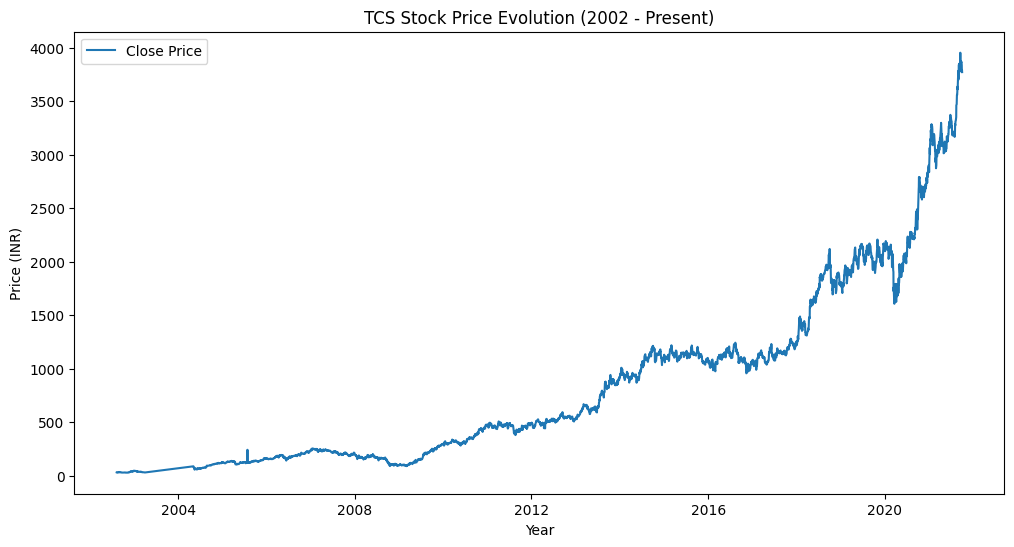

First available price: 29.51914024
Latest price: 3773.199951
Total stock price growth since 2002: 12682.21%


In [95]:
from matplotlib import pyplot as plt


plt.figure(figsize=(12,6))
plt.plot(history['Date'], history['Close'], label="Close Price")
plt.title("TCS Stock Price Evolution (2002 - Present)")
plt.xlabel("Year"); plt.ylabel("Price (INR)")
plt.legend(); plt.show()

print("First available price:", history['Close'].iloc[0])
print("Latest price:", history['Close'].iloc[-1])
growth = ((history['Close'].iloc[-1] / history['Close'].iloc[0]) - 1) * 100
print(f"Total stock price growth since {history['Date'].iloc[0].year}: {growth:.2f}%")


Q2: What has been the impact of dividends and stock splits on TCS stock price and trading volume?
(action + history)

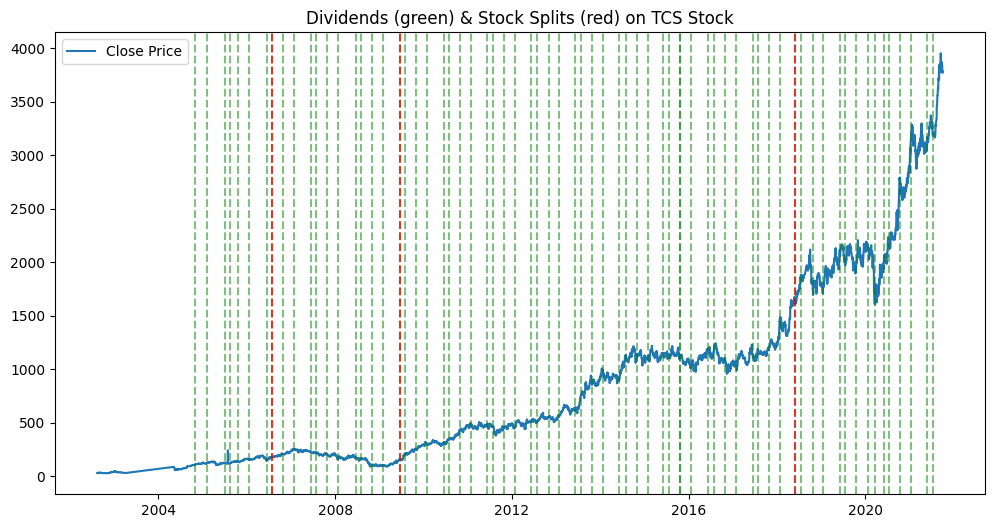

Total dividends recorded: 319.25
Number of stock splits: 3


In [96]:
merged = pd.merge(history, action, on="Date", how="left").fillna(0)

plt.figure(figsize=(12,6))
plt.plot(history['Date'], history['Close'], label="Close Price")
for d in action[action['Dividends']>0]['Date']:
    plt.axvline(d, color='green', linestyle='--', alpha=0.5)
for d in action[action['Stock Splits']>0]['Date']:
    plt.axvline(d, color='red', linestyle='--', alpha=0.7)

plt.title("Dividends (green) & Stock Splits (red) on TCS Stock")
plt.legend(); plt.show()

print("Total dividends recorded:", action['Dividends'].sum())
print("Number of stock splits:", (action['Stock Splits']>0).sum())


Q3: Which years had the highest returns for investors, considering both price growth and dividends?
(history + action)

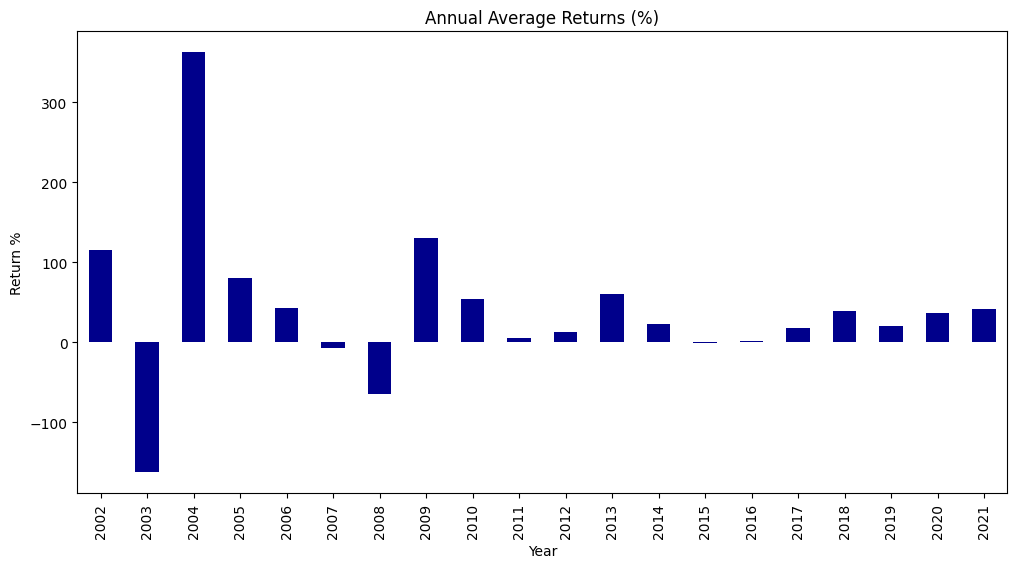

Top 5 Years by Returns:
Year
2004    362.211521
2009    130.189854
2002    114.925626
2005     80.518690
2013     60.451904
Name: Daily Return, dtype: float64


In [97]:
# Calculate daily returns (percentage change in closing price)
history['Daily Return'] = history['Close'].pct_change()

history['Year'] = history['Date'].dt.year
annual_returns = history.groupby('Year')['Daily Return'].mean() * 252 * 100

plt.figure(figsize=(12,6))
annual_returns.plot(kind="bar", color="darkblue")
plt.title("Annual Average Returns (%)")
plt.ylabel("Return %")
plt.show()

print("Top 5 Years by Returns:")
print(annual_returns.sort_values(ascending=False).head())


Q4: How volatile is TCS stock, and how did it behave during major market events (e.g., 2008 crisis, 2020 COVID)?
(history)

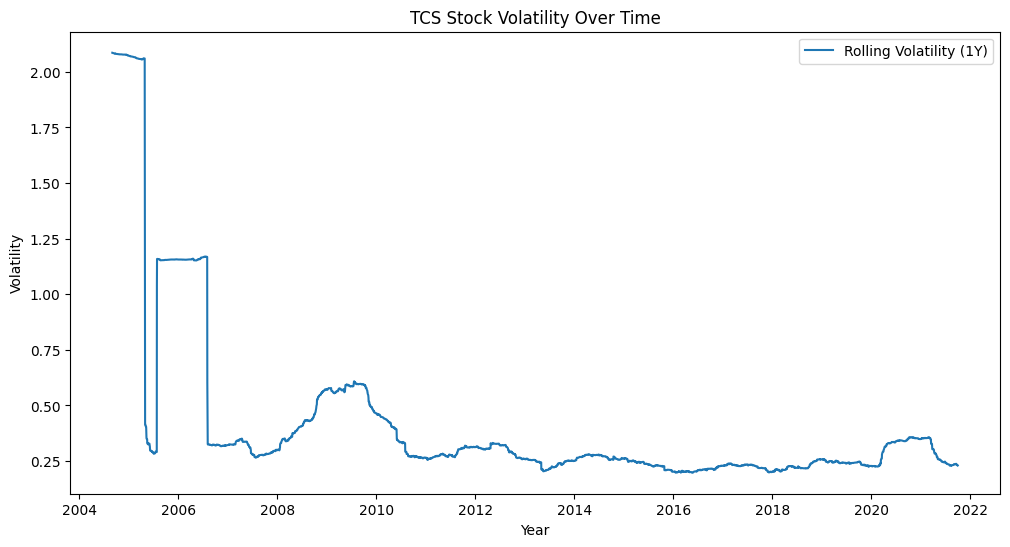

Highest volatility period: 2004-09-02 00:00:00


In [98]:
rolling_vol = history['Daily Return'].rolling(window=252).std() * np.sqrt(252)

plt.figure(figsize=(12,6))
plt.plot(history['Date'], rolling_vol, label="Rolling Volatility (1Y)")
plt.title("TCS Stock Volatility Over Time")
plt.xlabel("Year"); plt.ylabel("Volatility")
plt.legend(); plt.show()

print("Highest volatility period:", history.iloc[rolling_vol.idxmax()]['Date'])


Q5: What is the cumulative return for a long-term investor who held TCS stock since the early 2000s, including dividends?
(history + action)

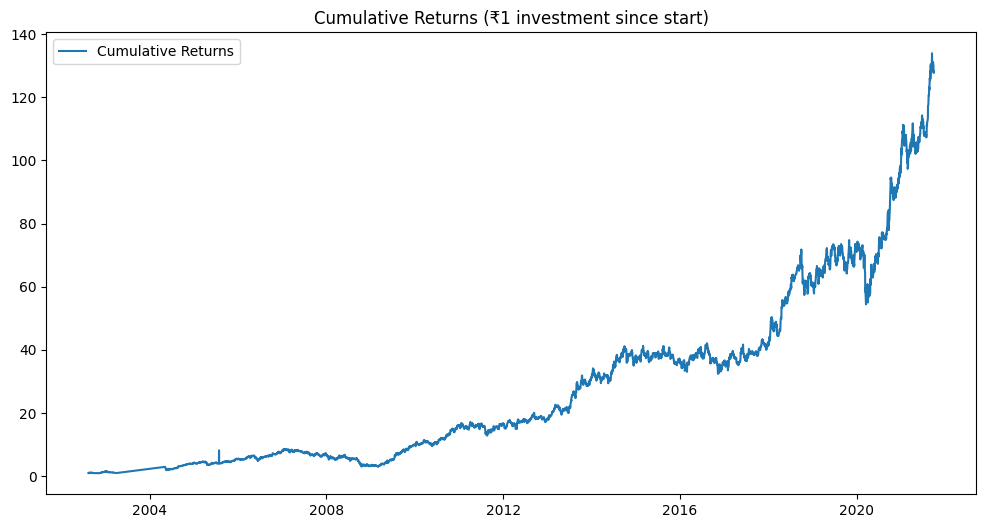

₹1 invested in 2002 is now worth: ₹127.82


In [99]:
history['Cum_Returns'] = (1 + history['Daily Return']).cumprod()
plt.figure(figsize=(12,6))
plt.plot(history['Date'], history['Cum_Returns'], label="Cumulative Returns")
plt.title("Cumulative Returns (₹1 investment since start)")
plt.legend(); plt.show()

final_cum = history['Cum_Returns'].iloc[-1]
print(f"₹1 invested in {history['Date'].iloc[0].year} is now worth: ₹{final_cum:.2f}")


Q6: Do corporate fundamentals (profit margins, revenue growth, operating cash flow) align with stock performance trends?
(info + history)

Profit Margins: 0.20103
Revenue Growth: 0.185
Operating Margins: 0.26288
EBITDA Margins: 0.27843


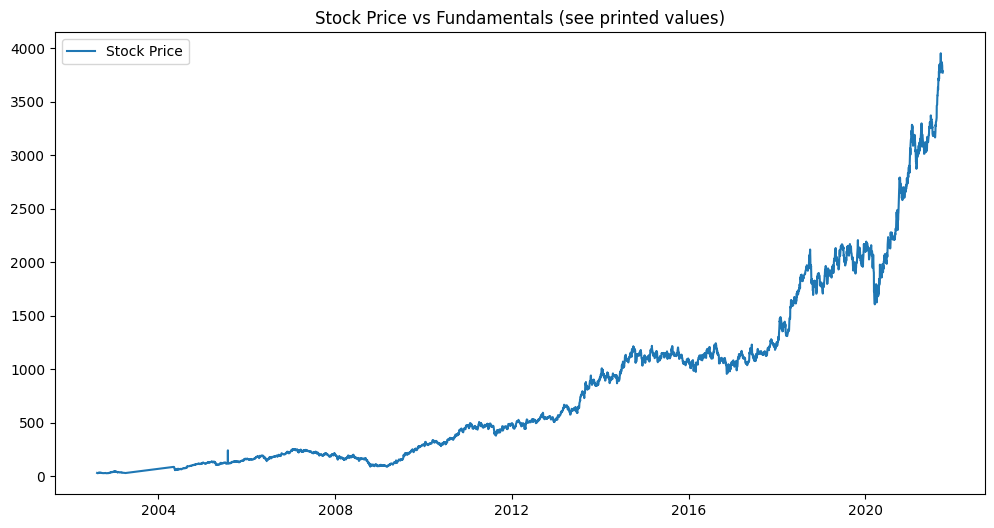

In [100]:
print("Profit Margins:", info_dict.get("profitMargins", "Unknown"))
print("Revenue Growth:", info_dict.get("revenueGrowth", "Unknown"))
print("Operating Margins:", info_dict.get("operatingMargins", "Unknown"))
print("EBITDA Margins:", info_dict.get("ebitdaMargins", "Unknown"))

plt.figure(figsize=(12,6))
plt.plot(history['Date'], history['Close'], label="Stock Price")
plt.title("Stock Price vs Fundamentals (see printed values)")
plt.legend(); plt.show()


Q7: How many stock splits occurred, and how did they affect affordability and market participation (volume changes)?
(action + history)

Stock Splits:
          Date  Stock Splits
7  2006-07-28             2
18 2009-06-16             2
55 2018-05-31             2


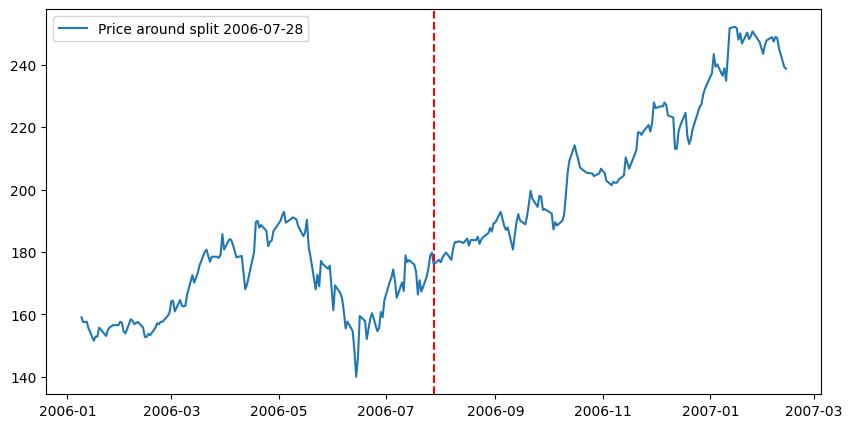

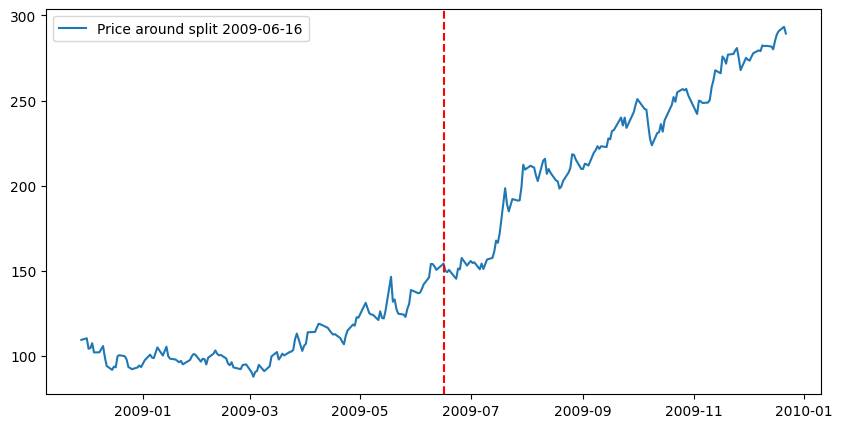

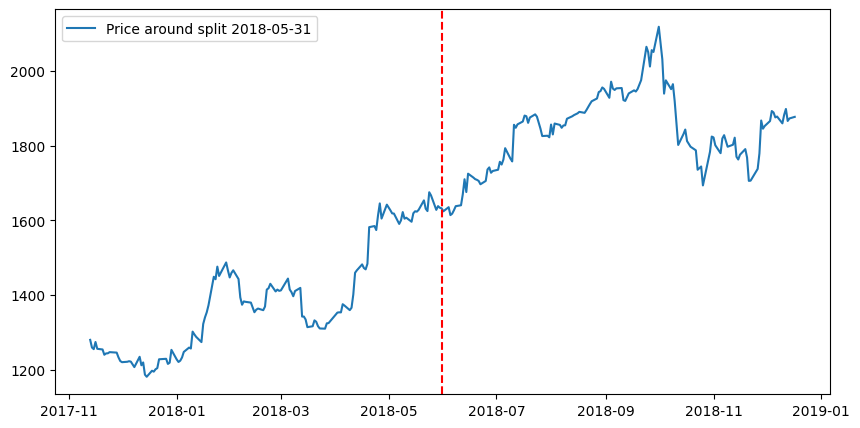

In [101]:
splits = action[action['Stock Splits'] > 0]
print("Stock Splits:\n", splits[['Date','Stock Splits']])

for d in splits['Date']:
    subset = history[(history['Date'] >= d - pd.Timedelta(days=200)) &
                     (history['Date'] <= d + pd.Timedelta(days=200))]
    plt.figure(figsize=(10,5))
    plt.plot(subset['Date'], subset['Close'], label=f"Price around split {d.date()}")
    plt.axvline(d, color='red', linestyle='--')
    plt.legend(); plt.show()


Q8: What is the dividend policy of TCS over time, and how does it compare to its profitability margins?
(action + info)

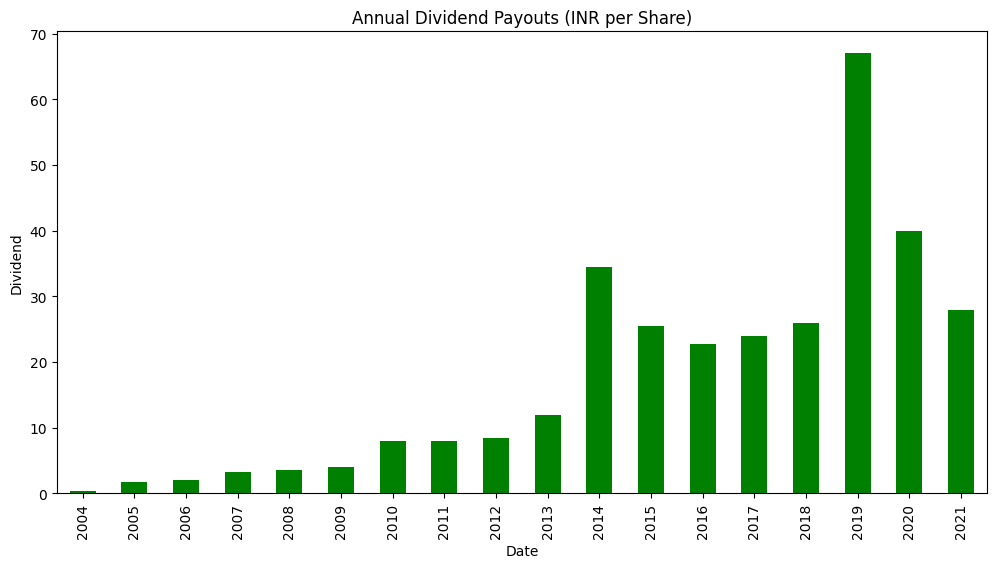

Profit Margins: 0.20103
Total Dividend Paid: 319.25


In [102]:
annual_div = action.groupby(action['Date'].dt.year)['Dividends'].sum()

plt.figure(figsize=(12,6))
annual_div.plot(kind="bar", color="green")
plt.title("Annual Dividend Payouts (INR per Share)")
plt.ylabel("Dividend"); plt.show()

print("Profit Margins:", info_dict.get("profitMargins", "Unknown"))
print("Total Dividend Paid:", annual_div.sum())


Q9: What do analysts recommend for TCS stock today (buy/hold/sell), and does this align with historical performance?
(info + history)

In [103]:
print("Analyst Recommendation:", info_dict.get("recommendationKey", "Unknown"))
print("Target Low Price:", info_dict.get("targetLowPrice", "Unknown"))
print("Target High Price:", info_dict.get("targetHighPrice", "Unknown"))
print("Current Price:", history['Close'].iloc[-1])


Analyst Recommendation: buy
Target Low Price: 2750
Target High Price: 4578
Current Price: 3773.199951


Q10: Overall, how has TCS rewarded its shareholders in terms of price appreciation, dividend payouts, and business growth?
(history + action + info)

In [104]:
total_dividends = action['Dividends'].sum()
initial_price = history['Close'].iloc[0]
final_price = history['Close'].iloc[-1]

total_return = ((final_price + total_dividends) / initial_price - 1) * 100

print("Initial Price:", initial_price)
print("Final Price:", final_price)
print("Total Dividends per Share:", total_dividends)
print(f"Total Return since {history['Date'].iloc[0].year}: {total_return:.2f}%")


Initial Price: 29.51914024
Final Price: 3773.199951
Total Dividends per Share: 319.25
Total Return since 2002: 13763.72%
